In [ ]:
!pwd

/content


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification
!unzip /content/ham1000-segmentation-and-classification.zip

In [ ]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-zs0hko35
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-zs0hko35
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=75f710e49a73facd1720d0dadce44f44f0451e7f267db72bfe3b676e6fe69e85
  Stored in directory: /tmp/pip-ephem-wheel-cache-0no4xn7b/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import Image
import shap
from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.pyplot import imshow

In [ ]:
def undersample(df, count, rs=42):
  result=[]
  df_group = df.groupby('dx')
  for x in df['dx'].unique():
    group = df_group.get_group(x)
    num = int(group['dx'].value_counts())
    if num >= count:
      s=group.sample(count, axis=0, random_state=rs)
    else:
      s=group.sample(frac=1, axis=0, random_state=rs)
    result.append(s)
  return pd.concat(result, axis=0).reset_index(drop=True)

def oversample(df, count, rs=42):
  lst = [df]
  for class_index, group in df.groupby('dx'):
      lst.append(group.sample(count-len(group), replace=True, random_state=rs))
  df_new = pd.concat(lst)
  return df_new

def img_np_convert(df, image_path, h, w):
  df['image_id'] = image_path + df['image_id'] +'.jpg'
  df['image'] = df['image_id'].map(lambda x: np.asarray(Image.open(x).resize((h, w))).astype(np.float32))
  return df

def img_np_convert_scaled(df, image_path, h, w):
  df['image_id'] = image_path + df['image_id'] +'.jpg'
  df['image'] = df['image_id'].map(lambda x: (np.asarray(Image.open(x).resize((h, w)))/255).astype(np.float32))
  return df

def my_split(df, train_size, test_size, val_size, rs=42):
  valid_test_split = val_size / test_size

  df_train, df_test_val = train_test_split(df, test_size=1-train_size, shuffle=True, random_state=rs)
  df_val, df_test = train_test_split(df_test_val, test_size=valid_test_split, shuffle=True, random_state=rs)

  df_train.reset_index(inplace=True)
  return df_train, df_test, df_val

def weight_cal(df):
  class_weight={}
  labels = list(df['dx'].unique())
  labels.sort()
  count = df['dx'].value_counts()
  for idx in range(7):
    class_weight[idx] = count['nv']/count[labels[idx]]
  return class_weight, labels

def df_to_np1(df):
  image = np.asarray(df['image'].to_list())

  df_feature = df.iloc[:, 3:-1]
  c_feature = df_feature.loc[:, ~df_feature.columns.isin(['sex', 'dx'])].to_numpy()

  target_df = df['dx']
  target = pd.get_dummies(data=target_df, columns=['dx']).to_numpy()
  return image, c_feature, target

def df_to_np2(df):
  df['image'] = df['image'].map(lambda x : x.flatten())
  i_feature = np.asarray(df['image'].tolist())
  df_feature = df.iloc[:, 3:-1]
  c_feature = df_feature.loc[:, ~df_feature.columns.isin(['sex', 'dx'])].to_numpy()
  features = np.concatenate((i_feature, c_feature), axis=1)
  
  target_df = df['dx']
  target = pd.get_dummies(data=target_df, columns=['dx']).to_numpy()
  return features, target

def image_augment(df, target, count, size, rs=42):
  df_group = df.groupby('dx')
  group = df_group.get_group(target)
  s=group.sample(count, axis=0, random_state=rs)

  datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode='nearest')
  
  for index, row in s.iterrows():
    image = row['image'].reshape((1, ) + row['image'].shape)
    gen = datagen.flow(image, batch_size=size)
    input = row.to_list()
    for i in range(size):
      img = next(gen)
      input[-1] = img[0]
      df.loc[len(df.index)] = input
  return None

In [ ]:
def prep_pipeline1(upper_size, h, w, aug_targets, aug_count, aug_size, rs=42):
  df_o = pd.read_csv('../content/drive/MyDrive/DSE_I2100/data/HAM10000_metadata.csv')
  df_o = pd.get_dummies(data=df_o, columns=['dx_type', 'localization'])
  image_path = r'../content/images/'
  df_u = undersample(df_o, upper_size)
  df_u['age'].fillna(value=int(df_u['age'].mean()), inplace=True)
  df_u['age'] = df_u['age'].astype(np.float32)
  
  df = img_np_convert(df_u, image_path, h, w)

  df_train, df_test, df_val = my_split(df, 0.7, 0.2, 0.1, rs)

  for target in aug_targets:
    image_augment(df_train, target, aug_count, aug_size, rs)

  weight, labels = weight_cal(df_train)

  X_train_i, X_train_c, y_train = df_to_np1(df_train)
  X_test_i, X_test_c, y_test = df_to_np1(df_test)
  return (X_train_i, X_train_c, y_train), (X_test_i, X_test_c, y_test), weight, labels

In [ ]:
h = 90
w = 90
aug_targets = ['mel', 'bcc']
aug_count = 0
aug_size = 0

train_set, test_set, class_weight, labels = prep_pipeline1(1500, h, w, aug_targets, aug_count, aug_size)

In [ ]:
X_train = train_set[0]
y_train = train_set[2]

X_test = test_set[0]
y_test = test_set[2]

In [ ]:
print(X_train.shape, X_test.shape)

(3366, 90, 90, 3) (722, 90, 90, 3)


In [ ]:
train_set[1].shape

(3366, 20)

In [ ]:
print(y_train.shape, y_test.shape)

(3366, 7) (722, 7)


In [ ]:
class_weight[4] = class_weight[4]*1.5
class_weight[1] = class_weight[1]*1.5

In [ ]:
class_weight

{0: 4.648888888888889,
 1: 3.0406976744186047,
 2: 1.378129117259552,
 3: 12.452380952380953,
 4: 1.285012285012285,
 5: 1.0,
 6: 11.127659574468085}

In [ ]:
histories = {}

channels = 3
img_shape = (h, w, channels)

def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')      
  ]

# Create the base model with EfficientNetB1
base_model = tf.keras.applications.EfficientNetB1(input_shape=img_shape, include_top=False, weights='imagenet', pooling='max')

Normalizator_layer = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )

prediction_layer = keras.layers.Dense(7, activation='softmax')

model = tf.keras.Sequential([
  base_model,
  Normalizator_layer,
  keras.layers.Dense(256, 
                     kernel_regularizer = regularizers.l2(l = 0.02),
                     activation='relu'),
  keras.layers.Dropout(rate=.5, seed=42),
  prediction_layer                           
])

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train, 
                    epochs=25, 
                    validation_split=0.2, 
                    callbacks=get_callbacks(),
                    class_weight=class_weight)

Epoch 1/25
85/85 [==============================] - 25s 142ms/step - loss: 12.9654 - accuracy: 0.3284 - val_loss: 10.0867 - val_accuracy: 0.2982 - lr: 0.0010
Epoch 2/25
85/85 [==============================] - 9s 105ms/step - loss: 10.6296 - accuracy: 0.5015 - val_loss: 9.6083 - val_accuracy: 0.3917 - lr: 0.0010
Epoch 3/25
85/85 [==============================] - 9s 105ms/step - loss: 9.6085 - accuracy: 0.5854 - val_loss: 8.8892 - val_accuracy: 0.4881 - lr: 0.0010
Epoch 4/25
85/85 [==============================] - 9s 105ms/step - loss: 8.9077 - accuracy: 0.6360 - val_loss: 8.3868 - val_accuracy: 0.5593 - lr: 0.0010
Epoch 5/25
85/85 [==============================] - 9s 104ms/step - loss: 8.4127 - accuracy: 0.6891 - val_loss: 8.0871 - val_accuracy: 0.5519 - lr: 0.0010
Epoch 6/25
85/85 [==============================] - 9s 104ms/step - loss: 7.9360 - accuracy: 0.7106 - val_loss: 7.8148 - val_accuracy: 0.5579 - lr: 0.0010
Epoch 7/25
85/85 [==============================] - 9s 103ms/step 

In [ ]:
shap.initjs()

In [ ]:
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=labels)

explainer

In [ ]:
shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 2/4 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 4/4 [00:18<00:00,  2.91s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 5it [00:24,  8.03s/it]


(4, 90, 90, 3, 5)

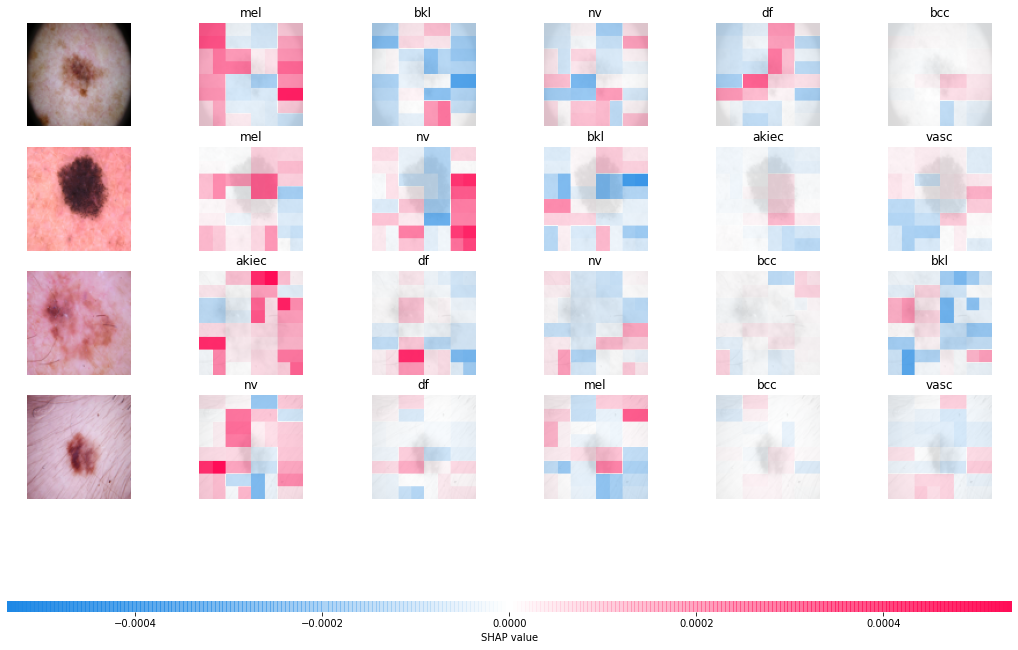

In [ ]:
shap.image_plot(shap_values)

In [ ]:
histories['EfficientNetB1'] = history

(0.0, 1.0)

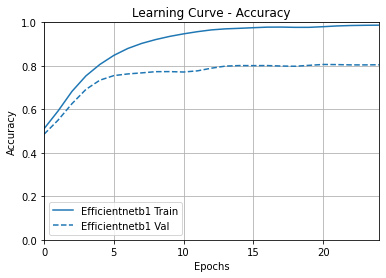

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)
plt.title("Learning Curve - Accuracy") 
plt.ylim([0, 1])

(0.0, 20.0)

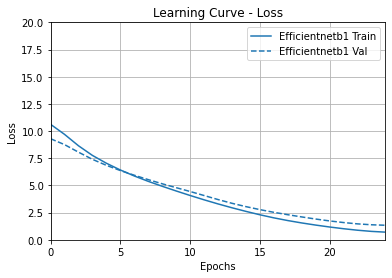

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(histories)
plt.title("Learning Curve - Loss") 
plt.ylim([0, 20])

In [ ]:
pred=model.predict(X_test)
y_pred=[]
for p in pred:
  pred_index=np.argmax(p)
  y_pred.append(pred_index)
y_ture=[]
for p in y_test:
  pred_index=np.argmax(p)
  y_ture.append(pred_index)
y_true = np.array(y_ture)
y_pred = np.array(y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

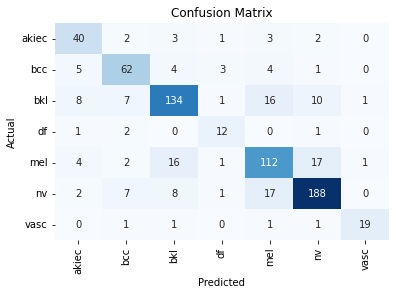

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(7)+0.5, labels, rotation= 90)
plt.yticks(np.arange(7)+0.5, labels, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix") 

In [ ]:
clr = classification_report(y_true, y_pred, target_names=labels)
print("Classification Report:")
print("=====================================================")
print(clr)

Classification Report:
              precision    recall  f1-score   support

       akiec       0.67      0.78      0.72        51
         bcc       0.75      0.78      0.77        79
         bkl       0.81      0.76      0.78       177
          df       0.63      0.75      0.69        16
         mel       0.73      0.73      0.73       153
          nv       0.85      0.84      0.85       223
        vasc       0.90      0.83      0.86        23

    accuracy                           0.79       722
   macro avg       0.76      0.78      0.77       722
weighted avg       0.79      0.79      0.79       722



In [ ]:
model.evaluate(X_test, y_test)

23/23 [==============================] - 2s 99ms/step - loss: 1.3444 - accuracy: 0.7853


[1.3444081544876099, 0.7853185534477234]

In [ ]:
h = 240
w = 240
aug_targets = ['mel', 'bcc']
aug_count = 50
aug_size = 2

train_set, test_set, val_set, class_weight, labels = prep_pipeline1(6000, h, w, aug_targets, aug_count, aug_size)

In [ ]:
X_train = train_set[0]
y_train = train_set[1]

X_val = val_set[0]
y_val = val_set[1]

X_test = test_set[0]
y_test = test_set[1]

In [ ]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 5s 103ms/step - loss: 0.4865 - accuracy: 0.8955


[0.4865286648273468, 0.8954903483390808]